In [211]:
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from matplotlib import cm as c
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA 


cm=plt.get_cmap('nipy_spectral') # for the plotting
df=pd.read_csv('ready_data.csv',sep=';' )
dt=pd.read_csv('final_test.csv',sep=',' )

#remove index from cleaning
ll=list(dt.columns)
ll.remove('X')# remove index first
dt=dt.loc[:,ll]


### Map the Varible " Zone" in the Test Set to the right integers: ( not important to read )

For the variable Zone we change the decimal values to an integer.
For test set we have to be consistent with train set.

In [212]:
train=pd.read_csv('TrainSample.csv',sep=';' )
test=pd.read_csv('TestSample.csv',sep=';' )
for a in test['API'].values:
    dt.loc[dt['API']==a,'Zone']=test[test['API']==a]['Zone'].values
#dt['Zone']

In [213]:
train=pd.read_csv('TrainSample.csv',sep=';' )
test=pd.read_csv('TrainSample.csv',sep=';' )
zz=train['Zone']
unique_vals=list(zz.unique())
old=[]

apis=[]
for i in range(460):
    v=train.iloc[i]['Zone']
    if  v not in old:
        old.append(train.iloc[i]['Zone'])
        apis.append(train.iloc[i]['API'])
    
new=[df[df['API']==apis[i]]['Zone'].values[0] for i in range(10)]
for i in range(10):
    dt.loc[dt['Zone']==old[i],'Zone']=int(new[i])
#old
#new

In [214]:
dt.loc[dt['Zone']%1 !=0,'Zone']=10
dt.loc[:,'Zone']=dt.loc[:,'Zone'].values.astype(int)

### Number of examples in each zone train vs test:

In [215]:
#dt[dt['Zone']%1 !=0]
zones_distribution=df.groupby('Zone')['API'].count()
print('Distribution into different Zones of Train Set \n')
print(zones_distribution)
print('')
zones_distribution2=dt.groupby('Zone')['API'].count()
print('Distribution into different Zones of Test Set \n')
print(zones_distribution2)

Distribution into different Zones of Train Set 

Zone
0    208
1     53
2     15
3      3
4      2
5     54
6    109
7      5
8      5
9      6
Name: API, dtype: int64

Distribution into different Zones of Test Set 

Zone
0     91
1     28
2      7
3      3
4      1
5     31
6     63
7      2
8      4
9      4
10     1
Name: API, dtype: int64


The distribution over the different zones in the test set is similar to the one in the train set.

**Equal prop test has to be done !!**

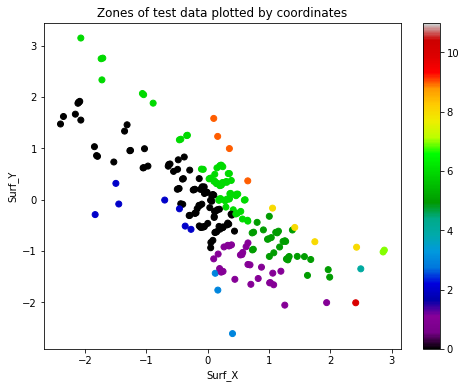

In [216]:
plt.figure(figsize=(8,6))
plt.title('Zones of test data plotted by coordinates')
plt.scatter(dt['Surf_X'],dt['Surf_Y'],color=cm((dt['Zone']+0)/11 ),cmap=cm)
plt.xlabel('Surf_X')
plt.ylabel('Surf_Y')
m = c.ScalarMappable(cmap=cm)
m.set_array([0,11])
plt.colorbar(m)

plt.show()



# Purpose of this script:
As seen in the script "Analysis Zone", the distribution of the 2 target variables, depends highly on the categorical varible 'Zone'. So, according to the 'Zone' we are going to split the data into 3 homogenous groups. We justify this grouping statistically afterwards.

## Plot Target Varibles grouped by Zone:


Text(0,0.5,'GasCum360')

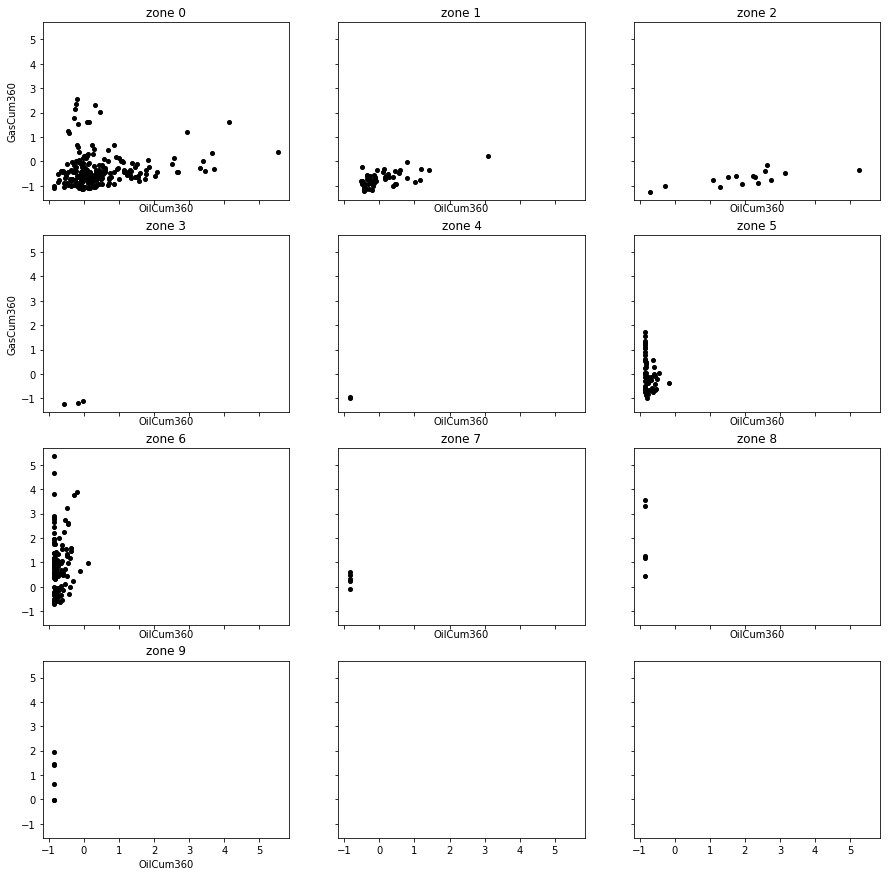

In [217]:
f, axarr = plt.subplots(ncols=3,nrows=4,sharex=True,sharey=True)
f.set_figheight(15)
f.set_figwidth(15)


zones=list()
plt.figure(figsize=(12,18))
count=0

for  i in zones_distribution.index:
    x=[ df['OilCum360'][j] for j in df.index if df['Zone'][j] ==i ] 
    y=[ df['GasCum360'][j] for j in df.index if df['Zone'][j] ==i ]
    axarr[int(count/3),count%3].plot( x,y,'.',ms=8,color='black')
    axarr[int(count/3),count%3].set_title("zone "+str(i))
    axarr[int(count/3),count%3].set_xlabel('OilCum360')
    count=count+1
axarr[0,0].set_ylabel('GasCum360')
axarr[1,0].set_ylabel('GasCum360')

## Group the examples into 3 groups. depending on the 'Zone'

By looking at the plots, we can do the follwowing grouping:



group 0:(low gas):             Zones 1,2,4, part of zone 0

group 1:(intermediate)         part of zone 0

group 2:(low oil):             Zones 5,6,7,8,9  part of zone 0


We need to split Zone 0 later. But for a first grouping, we leave zone 0 (unsplitted)  in group 1.

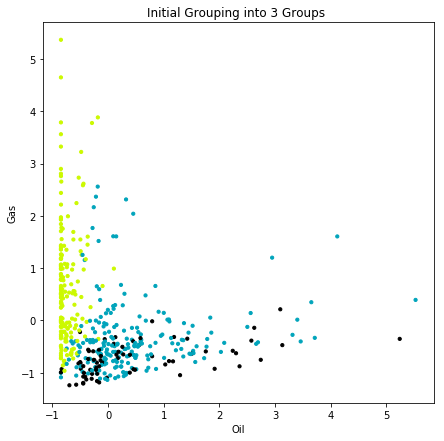

In [218]:
df['group']=5
# group 1
rows=(df['Zone']==1).values
df.loc[rows,'group']=0

rows=(df['Zone']==2).values
df.loc[rows,'group']=0

rows=(df['Zone']==3).values
df.loc[rows,'group']=0

rows=(df['Zone']==4).values
df.loc[rows,'group']=0

# group 1

rows=(df['Zone']==0).values
df.loc[rows,'group']=1


# group2
rows=(df['Zone']==5).values
df.loc[rows,'group']=2

rows=(df['Zone']==6).values
df.loc[rows,'group']=2

rows=(df['Zone']==7).values
df.loc[rows,'group']=2

rows=(df['Zone']==8).values
df.loc[rows,'group']=2

rows=(df['Zone']==9).values
df.loc[rows,'group']=2
plt.figure(figsize=(7,7))
plt.scatter(df['OilCum360'],df['GasCum360'],color=cm(df['group']/3),s=10)
plt.title('Initial Grouping into 3 Groups ')
plt.xlabel('Oil')
plt.ylabel('Gas')

df5=df.copy()

## Explained variance of the grouping

In [219]:
counts=[len(df[df['group']==i]) for i in range (3)]
var_o_exp=[np.var(df[df['group']==i]['OilCum360']) * counts[i] for i in range (3)]
var_o_exp=np.sum(var_o_exp)/len(df)

var_g_exp=[np.var(df[df['group']==i]['GasCum360']) * counts[i] for i in range (3)]
var_g_exp=np.sum(var_g_exp)/len(df)

print('oil variance unexplained: ' + str(np.var(df['OilCum360'])) )
print('oil variance explained:   ' + str(var_o_exp))
print('------------------------------------------------------')
print('gas variance unexplained: ' + str(np.var(df['GasCum360'])) )
print('gas variance explained:   ' + str(var_g_exp) )

oil variance unexplained: 0.971203712653
oil variance explained:   0.641813907819
------------------------------------------------------
gas variance unexplained: 1.02967386891
gas variance explained:   0.720268325234


## Anova Test

In [220]:
d=[df[df['group']==i] for i in range(3)]
oil=[dd['OilCum360'].values for dd in d]
gas=[dd['GasCum360'].values for dd in d]

In [221]:
print('oil, group 0 vs group 2')
print(stats.f_oneway(oil[0],oil[2]))
print('oil, group 0 vs group 1')
print(stats.f_oneway(oil[0],oil[1]))
print('oil, all three groups')
print(stats.f_oneway(oil[0],oil[1],oil[2]))
#############################################
print('___________________________________________________________________________________________')

print('gas, group 0 vs group 2')
print(stats.f_oneway(gas[0],gas[2]))
print('gas, group 0 vs group 1')
print(stats.f_oneway(gas[0],gas[1]))#
print('gas, all three groups')
print(stats.f_oneway(gas[0],gas[1],gas[2]))#


oil, group 0 vs group 2
F_onewayResult(statistic=171.81251541182206, pvalue=3.1453120644549421e-30)
oil, group 0 vs group 1
F_onewayResult(statistic=0.01858961803706018, pvalue=0.89164786730514778)
oil, all three groups
F_onewayResult(statistic=117.27008325562221, pvalue=7.8086056823933892e-42)
___________________________________________________________________________________________
gas, group 0 vs group 2
F_onewayResult(statistic=108.87733001756544, pvalue=2.1474169437778448e-21)
gas, group 0 vs group 1
F_onewayResult(statistic=25.647669739597486, pvalue=7.4587798073937557e-07)
gas, all three groups
F_onewayResult(statistic=98.156706678473128, pvalue=3.4321941851595945e-36)


## Interpretation:
For both target variables, splitting the data into the 3 groups is significant.

For oil prediction, splitting group 0 and group 1 is not significant, as they both have
a similar oil distribution.

 However we will try to improve the result by making a better split for zone 0.




##  Clustering of  Zone 0

To get an idea how do make a better split for zone 0, we use hierachical clustering of the target space with 
average, complete and ward link.

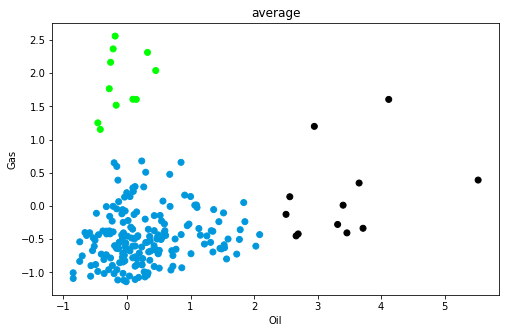

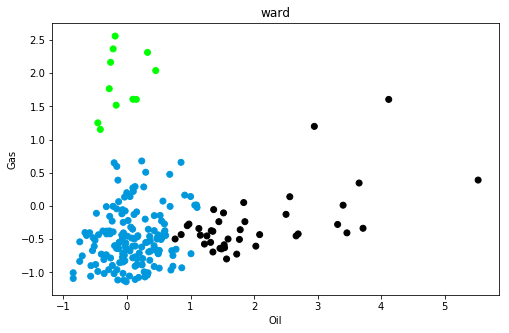

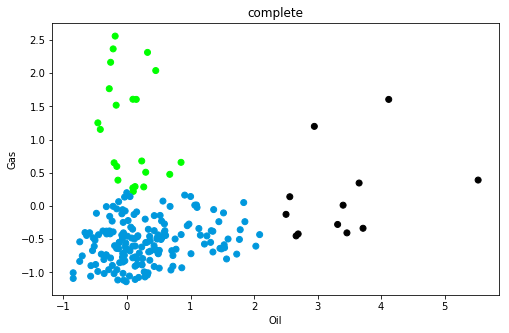

In [222]:

z0=df[df['Zone']==0]
score=[]
labels=[]
for linkage in ('average', 'ward','complete'):#complete is same as average
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=3)
    clustering.fit(z0.loc[:,['GasCum360','OilCum360']])
    labels2=clustering.labels_    
    plt.figure(figsize=(8,5))
    plt.scatter(z0['OilCum360'],z0['GasCum360'],color=cm(labels2*0.3))
    plt.title(linkage)
    plt.xlabel('Oil')
    plt.ylabel('Gas')
    labels.append(labels2)
    

## Choice of clustering.



In [223]:
## avergage:
rows=labels[0]==0
filters=np.zeros((3,3,len(z0))).astype(bool)
var_o=np.zeros(3)
var_g=np.zeros(3)
counts=np.zeros((3,3))
for i in range(3):
    for j in range(3):
        filters[i,j,:]=labels[i]==j
        counts[i,j]=np.sum(filters[i,j])
    vo=[np.var(z0.loc[filters[i,k,:],'OilCum360'])* counts[i,k] for k in range(3)]
    var_o[i]=np.sum(vo)
    vg=[np.var(z0.loc[filters[i,k,:],'GasCum360'])* counts[i,k] for k in range(3)]
    var_g[i]=np.sum(vg)

    
    
print('variance oil: '+ str(np.var(z0['OilCum360'])))
print()
print('oil residual sum of squares')
print('avg               ward          comp')
print(var_o/len(z0))
print('-------------------------------------------')
print('variance gas: '+ str(np.var(z0['GasCum360'])))
print()
print('gas residual sum of squares')
print('avg               ward          comp')
print(var_g/len(z0))






variance oil: 0.928699099708

oil residual sum of squares
avg               ward          comp
[ 0.39622764  0.34141825  0.39776744]
-------------------------------------------
variance gas: 0.454778608313

gas residual sum of squares
avg               ward          comp
[ 0.16916854  0.1822974   0.17031555]


We choose the ward clustering, as is has considerably lower residual sum of squares for oil and only a slightly higher one for gas.



##   Splitting of zone 0

We split Zone 0 similar to the ward-link clustering, but leaving the two points having high gas and high oil aside for now. ( Better results for svm later according to crossfold)

In [224]:
df['group']=5
###  Zone 0 going to group 3
rows=(df['Zone']==0).values
rows2=(df['GasCum360']>1).values
rows3=(df['OilCum360']<1.2).values
z0_group3=np.logical_and(rows2,rows)
z0_group3=np.logical_and(z0_group3,rows3)
df.loc[z0_group3,'group']=2

##  zone 0 going to group 2
rows4=(df['GasCum360']<1).values
z0_group2=np.logical_and(rows4,rows)
z0_group2=np.logical_and(rows3,z0_group2)
df.loc[z0_group2,'group']=1

##  zone 0 going to group 1
rows5=(df['OilCum360']>1.2).values
rows6=(df['GasCum360']<1).values
z0_group1=np.logical_and(rows,rows5)
z0_group1=np.logical_and(z0_group1,rows6)
df.loc[z0_group1,'group']=0



df2=df[df['Zone']==0].copy()

## Illustration of the splitting

Text(0,0.5,'Gas')

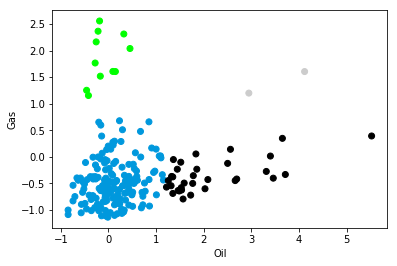

In [225]:
# verification
plt.scatter(df2['OilCum360'],df2['GasCum360'],color=cm(df2['group']*0.3))
plt.xlabel('Oil')
plt.ylabel('Gas')

## Training a svm classifier for prediction of the groups

### group 2 ( green) vs rest

As none of the examples with missing values ( after cleaning) falls into group 2, we can exclude them
before.

20 - fold score of class 1 with 11 members:  0.909090909091
20 - fold score of class 0 with 143 members: 0.979020979021


143

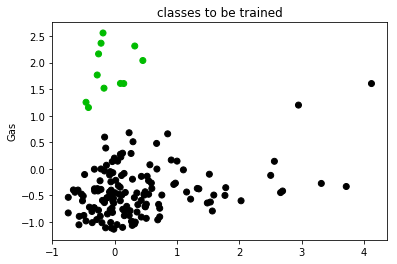

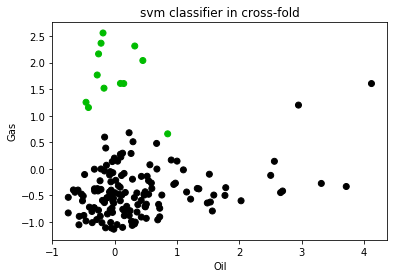

In [226]:
df3=df2[~np.isnan(df2['Nbr_Stages'])]

ind=list(df3.columns)
ind.remove('Zone')
ind.remove('API')


ind.remove('Unnamed: 0')
ind.remove('GasCum360')
ind.remove('OilCum360')

ind.remove('group')

######
z2=df3.loc[:,ind]

x=np.array(z2)
y=df3['group'].values


############# make it binary
for i in range(len(y)):# high gas vs low gas
    if y[i]==2:
        y[i]=1
    else:
        if y[i]==1:
            y[i]=0
        else:
            if y[i]==5:
                y[i]=0
       
plt.scatter(df3['OilCum360'],df3['GasCum360'],color=cm(y*0.5))  
plt.title('classes to be trained')

plt.ylabel('Gas')
zzzcount=len(y) -np.sum(y) # 11
######
scaler = StandardScaler()
x=np.array(scaler.fit_transform(x))

pca = PCA(25)
pca.fit(x)
sum=pca.explained_variance_ratio_ 
sum=[np.sum(sum[:i+1]) for i in range(len(sum))]
## first 16 have 95 % of variance 
xx=pca.transform(x)


 
 #################### select attributes
 
u=np.zeros((len(z2),len(xx[0])+1))
u[:,:len(xx[0])]=xx
u[:,len(xx[0])]=y
cor=np.corrcoef(np.transpose(u))
cor=np.abs(cor[:-1,-1])
 

sortet=np.zeros((len(cor),2))
for i in range(len(cor)):
    sortet[i]=[i,cor[i]]

sortet=pd.DataFrame(sortet)
sortet=sortet.sort_values(1,ascending=False)
sortet=sortet[sortet[1]>0.07] #0.07 is a good value
indic=sortet[0].values.astype(int)
X=xx[:,indic]#np.array(df3.loc[:,['DTs_PPLS (us/ft)','S3Tect_PPLS (PSI)']])
##############################################
clf = svm.SVC(class_weight='balanced',kernel='linear')

kf = KFold(n_splits=20)
score0=[]
score1=[]


for train, test in kf.split(df3):
    Xtr=X[train,:]
    Xt=X[test,:]
    ytr=y[train]
    yt=y[test]
    clf.fit(Xtr, ytr)  
    wt=(yt-0.5)*-1 +0.5
    score0.append(clf.score(Xt, yt,sample_weight=wt)*(len(yt)-np.sum(yt)))
    if np.sum(yt)>0:
        score1.append(clf.score(Xt, yt,sample_weight=yt)*np.sum(yt))
 
zscore0=np.sum(score0)/(len(y)-np.sum(y))
zscore1=np.sum(score1)/np.sum(y)

print('20 - fold score of class 1 with 11 members:  ' + str(zscore1))
print('20 - fold score of class 0 with 143 members: ' + str(zscore0))
######
#make it ready for deployment
clf.fit(X, y) 
zl=clf.predict(X)
plt.figure()
plt.scatter(df3['OilCum360'],df3['GasCum360'],color=cm((zl/2)))
plt.title('svm classifier in cross-fold')
plt.xlabel('Oil')
plt.ylabel('Gas')
zzzcount


As the classes are artifical anyway, we consider the above given class accuracies are sufficient. Hence we use the decision border of the svm trained on the complete data set to make our split.

## group 0 (green) vs rest

This time we have to include the examples with the missing values. To get complete lines, we use only 
a part of the features to train our svm classifier.

20 - fold score of class 1 with 28 members:  0.863636363636
20 - fold score of class 0 with 176 members: 0.875


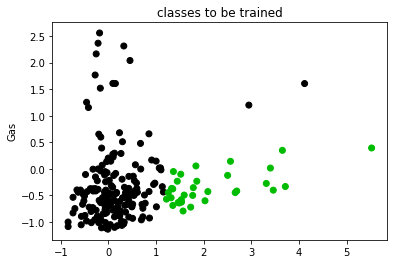

In [227]:
#print(len(df2))

ind=list(df2.columns)
ind.remove('Zone')
ind.remove('API')

ind.remove('Unnamed: 0')
ind.remove('GasCum360')
ind.remove('OilCum360')



for n in ind.copy():
    if np.sum(np.isnan(df2[n]))> 0:
        ind.remove(n)
        
######
df3=df2.loc[:,ind]
ind.remove('group')
z2=df3.loc[:,ind]
x=np.array(z2)
y=df3['group'].values


############# make it binary
for i in range(len(y)):# high gas vs low gas
    if y[i]>=1:
        y[i]=0
    else:
        if y[i]==0:
            y[i]=1
        
zzzcount=len(y) -np.sum(y) # 11
######



plt.scatter(df2['OilCum360'],df2['GasCum360'],color=cm(y*0.5))
plt.title('classes to be trained')
plt.ylabel('Gas')
scaler2 = StandardScaler()
x=np.array(scaler2.fit_transform(x))

pca2 = PCA(15)
pca2.fit(x)
sum=pca2.explained_variance_ratio_ 
sum=[np.sum(sum[:i+1]) for i in range(len(sum))]
## first 16 have 95 % of variance 
xx=pca2.transform(x)


 
 #################### select attributes
 
u=np.zeros((len(z2),len(xx[0])+1))
u[:,:len(xx[0])]=xx
u[:,len(xx[0])]=y
cor=np.corrcoef(np.transpose(u))
cor=np.abs(cor[:-1,-1])
 

sortet=np.zeros((len(cor),2))
for i in range(len(cor)):
    sortet[i]=[i,cor[i]]

sortet=pd.DataFrame(sortet)
sortet=sortet.sort_values(1,ascending=False)
sortet=sortet[sortet[1]>0.05]
indic2=sortet[0].values.astype(int)
X=xx[:,indic2]#np.array(df3.loc[:,['DTs_PPLS (us/ft)','S3Tect_PPLS (PSI)']])
##############################################
clf2 = svm.SVC(class_weight='balanced',kernel='linear')

kf2 = KFold(n_splits=20)
score0=[]
score1=[]


for train, test in kf2.split(df2):
    Xtr=X[train,:]
    Xt=X[test,:]
    ytr=y[train]
    yt=y[test]
    clf2.fit(Xtr, ytr)  
    wt=(yt-0.5)*-1 +0.5
    score0.append(clf2.score(Xt, yt,sample_weight=wt)*(len(yt)-np.sum(yt)))
   
    
    if np.sum(yt)>0:
        score1.append(clf2.score(Xt, yt,sample_weight=yt)*np.sum(yt))
 
zscore0=np.sum(score0)/(len(y)-np.sum(y))
zscore1=np.sum(score1)/np.sum(y)

print('20 - fold score of class 1 with 28 members:  ' + str(zscore0))
print('20 - fold score of class 0 with 176 members: ' + str(zscore1))
clf2.fit(X, y) 
zl2=clf2.predict(X)



Text(0.5,1,'svm classifier in cross-fold')

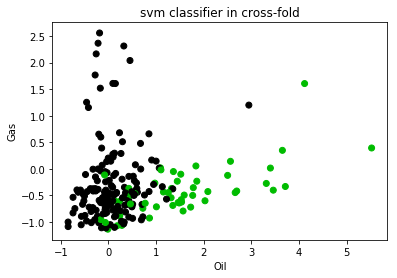

In [228]:
plt.figure()
plt.scatter(df2['OilCum360'],df2['GasCum360'],color=cm((zl2/2)))
plt.xlabel('Oil')
plt.ylabel('Gas')
plt.title('svm classifier in cross-fold')





In the crossfold result, we can see an interesting behaviour which could be analysed in a later script.

## Deployment ( zone 0, group 2)
Now we want to apply the trained svm models on the test examples of zone 0.
First we want to split off ( from zone 0) the examples falling into group 2.

In [229]:
#dft=df.loc[10:220,:] # ################################################## change for test set
#dt2=dt.loc[200:400,:]
dt['group']=1 #group 1 if no other group
dt2=dt.loc[dt['Zone']==0,:]
dt3=dt2.loc[~np.isnan(dt2['Nbr_Stages']),:]
### prepare data frame
indt=list(dt3.columns)
indt.remove('Zone')
indt.remove('API')
#indt.remove('Unnamed: 0')################################################## change for test set
#indt.remove('GasCum360')################################################## change for test set
#indt.remove('OilCum360')################################################## change for test set
indt.remove('group')


zt2=dt3.loc[:,indt]
xt=np.array(zt2)
#print(np.shape(xt))
# pca + normalization + feature selection
xt=np.array(scaler.transform(xt))
xxt=pca.transform(xt)
Xt=xxt[:,indic]
# apply the trained model
predt=clf.predict(Xt)

###write from binary to the three groups
group2=predt==1
rows=dt3.loc[group2,:].index
dt.loc[rows,'group']=2


### Verification of the splitting of the test set
As we do not have target varibales for the test set, we cannot verify the splitting as before.
What we can do is plot the split against coordinates.

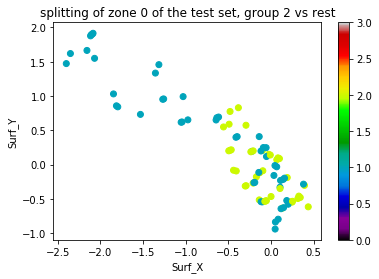

array([2, 1])

In [230]:
# verify whether seeting the group was effective on test df
plt.scatter(dt[dt['Zone']==0]['Surf_X'],dt[dt['Zone']==0]['Surf_Y'],color=cm(dt[dt['Zone']==0]['group']/3),cmap=cm)
plt.title('splitting of zone 0 of the test set, group 2 vs rest')
plt.xlabel('Surf_X')
plt.ylabel('Surf_Y')
m = c.ScalarMappable(cmap=cm)
m.set_array([0,3])
plt.colorbar(m)

plt.show()
dt[dt['Zone']==0]['group'].unique()

We can see that the group2 (yellow) predicted for the test set is locally connected ( coordinates).

##  Deployment ( zone 1 group 0)
Second we want to split off ( from zone 0) the examples falling into group 0.

In [231]:
indt2=indt.copy()

for n in indt2.copy():
    if np.sum(np.isnan(dt2[n]))> 0:
        indt2.remove(n)

zt3=dt2.loc[:,indt2]
xt2=np.array(zt3)
#print(np.shape(xt2))
# pca + normalization + feature selection
xt2=np.array(scaler2.transform(xt2))
xxt2=pca2.transform(xt2)
Xt2=xxt2[:,indic2]
# apply the trained model
predt2=clf2.predict(Xt2)
###write from binary to the three groups
group0=predt2==1
rows2=dt2.loc[group0,:].index
dt.loc[rows2,'group']=0

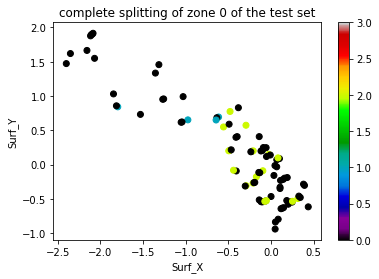

In [232]:
# verify whether seeting the group was effective on test df
plt.scatter(dt[dt['Zone']==0]['Surf_X'],dt[dt['Zone']==0]['Surf_Y'],color=cm(dt[dt['Zone']==0]['group']/3),cmap=cm,)
plt.title('complete splitting of zone 0 of the test set')
plt.xlabel('Surf_X')
plt.ylabel('Surf_Y')
m = c.ScalarMappable(cmap=cm)
m.set_array([0,3])
plt.colorbar(m)

plt.show()


### Remark:
Group 0 seems to be much bigger than expected from the relative size of group 0 in the train set (see plot below). This migth have to be investigated further. Probably the test set examples in zone 0 have a different distribution in the variables that the svm is sensitive to.

Text(0.5,1,' group 0 in zone 0 in train set for comparison')

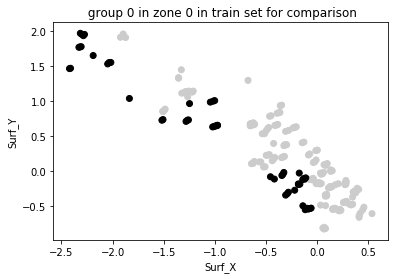

In [233]:
plt.figure()
plot1=plt.scatter(df2['Surf_X'],df2['Surf_Y'],color=cm(((zl2/-2 +0.5)*2)),cmap=cm)
plt.xlabel('Surf_X')
plt.ylabel('Surf_Y')
m = c.ScalarMappable(cmap=cm)
m.set_array([0,1.3])
plt.title(' group 0 in zone 0 in train set for comparison')


## write the groups to the other zones of the test data frame

In [234]:
# group 0
rows=(dt['Zone']==1).values
dt.loc[rows,'group']=0

rows=(dt['Zone']==2).values
dt.loc[rows,'group']=0

rows=(dt['Zone']==3).values
dt.loc[rows,'group']=0

rows=(dt['Zone']==4).values
dt.loc[rows,'group']=0


# group2
rows=(dt['Zone']==5).values
dt.loc[rows,'group']=2

rows=(dt['Zone']==6).values
dt.loc[rows,'group']=2

rows=(dt['Zone']==7).values
dt.loc[rows,'group']=2

rows=(dt['Zone']==8).values
dt.loc[rows,'group']=2

rows=(dt['Zone']==9).values
dt.loc[rows,'group']=2

rows=(dt['Zone']==10).values
dt.loc[rows,'group']=2




Text(0,0.5,'Surf_Y')

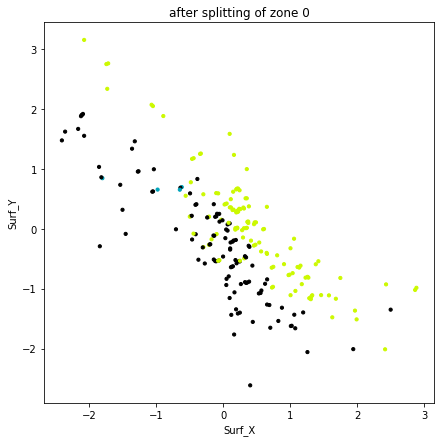

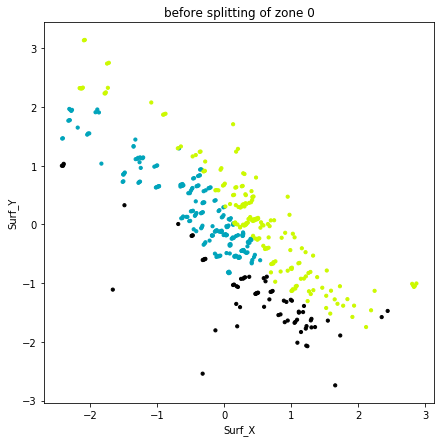

In [235]:
# verification


plt.figure(figsize=(7,7))
plt.scatter(dt['Surf_X'],dt['Surf_Y'],color=cm(dt['group']/3),s=10)
plt.title('after splitting of zone 0')
plt.xlabel('Surf_X')
plt.ylabel('Surf_Y')
plt.figure(figsize=(7,7))
plt.scatter(df5['Surf_X'],df5['Surf_Y'],color=cm(df5['group']/3),s=10)
plt.title('before splitting of zone 0')
plt.xlabel('Surf_X')
plt.ylabel('Surf_Y')


In [360]:
dt.to_csv('partitionned_test_final.csv')
# note: eventually making a fourth group is better bc the high gas ones of zone 0 have higher oil than the 
# others in group 3

# Statistical Validation of the final grouping ( on the train set)
now we also want to validate the final grouping of the train set statistically.


In [207]:
dt=df.copy()
dt['group']=1#group 1 if no other group
dt2=dt.loc[dt['Zone']==0,:]
dt3=dt2.loc[~np.isnan(dt2['Nbr_Stages']),:]
### prepare data frame
indt=list(dt3.columns)
indt.remove('Zone')
indt.remove('API')
indt.remove('Unnamed: 0')################################################## change for test set
indt.remove('GasCum360')################################################## change for test set
indt.remove('OilCum360')################################################## change for test set
indt.remove('group')


zt2=dt3.loc[:,indt]
xt=np.array(zt2)
#print(np.shape(xt))
# pca + normalization + feature selection
xt=np.array(scaler.transform(xt))
xxt=pca.transform(xt)
Xt=xxt[:,indic]
# apply the trained model
predt=clf.predict(Xt)

###write from binary to the three groups
group2=predt==1
rows=dt3.loc[group2,:].index
dt.loc[rows,'group']=2

In [208]:
indt2=indt.copy()

for n in indt2.copy():
    if np.sum(np.isnan(dt2[n]))> 0:
        indt2.remove(n)

zt3=dt2.loc[:,indt2]
xt2=np.array(zt3)
#print(np.shape(xt2))
# pca + normalization + feature selection
xt2=np.array(scaler2.transform(xt2))
xxt2=pca2.transform(xt2)
Xt2=xxt2[:,indic2]
# apply the trained model
predt2=clf2.predict(Xt2)
###write from binary to the three groups
group0=predt2==1
rows2=dt2.loc[group0,:].index
dt.loc[rows2,'group']=0

In [209]:
# group 0
rows=(dt['Zone']==1).values
dt.loc[rows,'group']=0

rows=(dt['Zone']==2).values
dt.loc[rows,'group']=0

rows=(dt['Zone']==3).values
dt.loc[rows,'group']=0

rows=(dt['Zone']==4).values
dt.loc[rows,'group']=0


# group2
rows=(dt['Zone']==5).values
dt.loc[rows,'group']=2

rows=(dt['Zone']==6).values
dt.loc[rows,'group']=2

rows=(dt['Zone']==7).values
dt.loc[rows,'group']=2

rows=(dt['Zone']==8).values
dt.loc[rows,'group']=2

rows=(dt['Zone']==9).values
dt.loc[rows,'group']=2


## Explained variance and anova for the split in zone 0:

In [210]:
counts=[len(dt[dt['group']==i]) for i in range (3)]
var_o_exp=[np.var(dt[dt['group']==i]['OilCum360']) * counts[i] for i in range (3)]
var_o_exp=np.sum(var_o_exp)/len(dt)

var_g_exp=[np.var(dt[dt['group']==i]['GasCum360']) * counts[i] for i in range (3)]
var_g_exp=np.sum(var_g_exp)/len(dt)

print('oil variance unexplained: ' + str(np.var(dt['OilCum360'])) )
print('oil variance explained:   ' + str(var_o_exp))
print('------------------------------------------------------')
print('gas variance unexplained: ' + str(np.var(dt['GasCum360'])) )
print('gas variance explained:   ' + str(var_g_exp) )
print('------------------------------------------------------')# 64,72
print('explained variance before split of zone 0')
print('oil variance explained:   0.642  ')
print('gas variance explained:   0.720  ' )

oil variance unexplained: 0.971203712653
oil variance explained:   0.558807617683
------------------------------------------------------
gas variance unexplained: 1.02967386891
gas variance explained:   0.635956454747
------------------------------------------------------
explained variance before split of zone 0
oil variance explained:   0.642  
gas variance explained:   0.720  


As the spitting of zone 0 lead to an inscrease of explained variance, we expect to have better ( = lower ) p- values as well
## Anova test for the final groups


In [203]:
d=[dt[dt['group']==i] for i in range(3)]
oil=[dd['OilCum360'].values for dd in d]
gas=[dd['GasCum360'].values for dd in d]

In [204]:
print('oil')
#print(stats.f_oneway(oil[0],oil[2]))
#print(str(stats.f_oneway(oil[0],oil[1]))+ " before: 0.89")
print(str(stats.f_oneway(oil[0],oil[1],oil[2]))+ " before: 7.81 e-42")
#############################################
print('___________________________________________________________________________________________')
print('gas')

#print(stats.f_oneway(gas[0],gas[2]))
#print(stats.f_oneway(gas[0],gas[1]))
print(str(stats.f_oneway(gas[0],gas[1],gas[2]))+ " before: 3.43 e-36")#


oil
F_onewayResult(statistic=168.63139427377212, pvalue=1.4093806829943144e-55) before: 7.81 e-42
___________________________________________________________________________________________
gas
F_onewayResult(statistic=141.46319054496789, pvalue=1.5180174786863016e-48) before: 3.43 e-36



To sum up, the final grouping into the three groups has significantly reduced variance, and is significantly better than  the initial grouping.